In [26]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import os
import pandas as pd
import numpy as np
import math
import random
from PIL import Image


import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from torch._utils import _accumulate
# from . import config
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import functional as F
from torch import default_generator, randperm

from torchvision.transforms import CenterCrop
from torchvision.io import read_image
from torchvision import transforms
from torchvision import models

In [28]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [29]:
path_to_dir = '/content/drive/MyDrive/Recycling/'
os.listdir(path_to_dir)

['Dataset', 'dataset.csv', 'Training.ipynb']

In [30]:
classroom_names = {0: 'plastic',
                   1: 'metal',
                   2: 'glass'}

In [31]:
# Прасим датасет из директорий собираем пути к файлам и складываем в csv
def create_dataset(path: str) -> pd.DataFrame:
    # получим аудитории из альфы
    classes = os.listdir(path+'Dataset/')
    iter = 0
    pathes, labels = [], []
    labels_classrooms = {}
    for _class in classes:
      # получаем картинки аудиторий
      images = os.listdir(path+'Dataset/'+_class +'/')
      for _image in images:
        pathes.append(path+'Dataset/'+_class+'/'+_image)
        labels.append(iter)
      labels_classrooms[iter] = _class
      iter += 1

    # # получаем изображения из хаба
    # areas = os.listdir(path+'hub/')
    # for _area in areas:
    #   images = os.listdir(path+'hub/'+_area +'/')
    #   for _image in images:
    #     pathes.append(path+'hub/'+_area+'/'+_image)
    #     labels.append(iter)
    #   labels_classrooms[iter] = _area
    #   iter += 1


    # '/root/alpha/1.1.png , 1
    # dict {label: auditorium_name}
    data = {'pathes': pathes, 'labels': labels}

    return pd.DataFrame(data), labels_classrooms

In [32]:
df, labels_classrooms  = create_dataset(path_to_dir)
df

,pathes,labels
0,/content/drive/MyDrive/Recycling/Dataset/Plast...,0
1,/content/drive/MyDrive/Recycling/Dataset/Plast...,0
2,/content/drive/MyDrive/Recycling/Dataset/Plast...,0
3,/content/drive/MyDrive/Recycling/Dataset/Plast...,0
4,/content/drive/MyDrive/Recycling/Dataset/Plast...,0
...,...,...
5145,/content/drive/MyDrive/Recycling/Dataset/Metal...,1
5146,/content/drive/MyDrive/Recycling/Dataset/Metal...,1
5147,/content/drive/MyDrive/Recycling/Dataset/Metal...,1
5148,/content/drive/MyDrive/Recycling/Dataset/Metal...,1


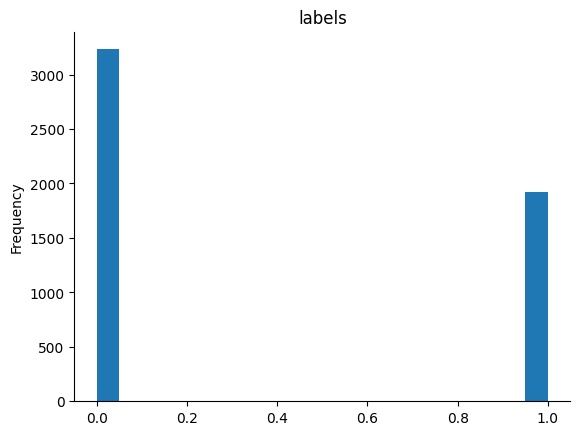

In [33]:
from matplotlib import pyplot as plt
df['labels'].plot(kind='hist', bins=20, title='labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [34]:
df.to_csv(path_to_dir+'dataset.csv')

In [35]:
len(labels_classrooms)

2

In [36]:
class ClassificationDataset(Dataset):
    """ Classification Dataset"""
    def __init__(self, root_dir, csv_file=None, image_csv=None, transforms=None):
        # получаем датафрейм
        if image_csv is not None:
            seg_csv = image_csv
        else:
            seg_csv = pd.read_csv(csv_file)
        # записываем названия файлов изображений и масок
        self.image_passes = seg_csv['pathes'].values # возращает массив
        self.image_labels = seg_csv['labels'].values

        # запомним корневую папку
        self.root_dir = root_dir
        self.transforms = transforms

    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.image_labels)

    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.image_passes[idx]
        label = self.image_labels[idx]

        image = Image.open(imagePath)
        # image = transforms.functional.rgb_to_grayscale(image, 1)

        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)

        # return a tuple of the image and its mask
        return (image, label)

In [37]:
def random_split(dataset, lengths, generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(math.floor(len(dataset) * frac))
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [38]:
# проверяй, чтобы совпадало
csv_path = path_to_dir + 'dataset.csv'
#csv_path = root_path + '/' + 'data_test.csv'
dataset = ClassificationDataset(root_dir = path_to_dir,
                              csv_file=csv_path,
                              transforms=transforms.Compose([
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                # Use mean and std for pretrained models
                                # https://pytorch.org/docs/stable/torchvision/models.html
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
                                ]))

len(dataset)

5150

In [39]:
train_set, valid_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

print(f'train set size: {len(train_set)}\nvalidation set size: {len(valid_set)}')

train set size: 4120
validation set size: 1030


In [40]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
  train_set,
  batch_size=batch_size,
  shuffle=False,
  drop_last=True)

valid_dataloader = torch.utils.data.DataLoader(
  valid_set,
  batch_size=batch_size,
  drop_last=True,
  shuffle=False)

In [41]:
# рандомно смотрим на пиксели
idx = np.random.randint(len(valid_set))
data, label = valid_set[idx]
print("Training Dataset length: {}".format(len(train_set)))
print("Validation Dataset length: {}".format(len(valid_set)))
print("Data shape: {}".format(data.shape))
print("Label: {}".format(label))

Training Dataset length: 4120
Validation Dataset length: 1030
Data shape: torch.Size([3, 256, 256])
Label: 0


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


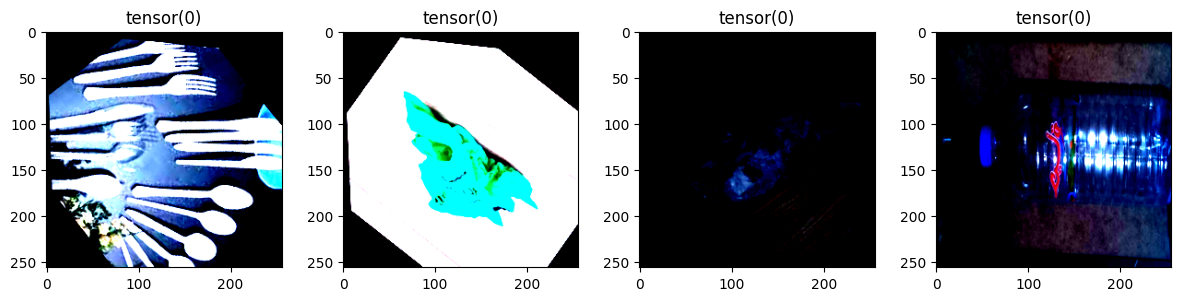

In [42]:
train_features, train_labels = next(iter(valid_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 10))
plt.tight_layout(pad=1, h_pad=1, w_pad=1)
for i in range(4):
    idx = random.randint(0,32)
    img = train_features[idx]#.squeeze()
    label = train_labels[idx]
    # new_img = np.array([_img for _img in img.numpy()[::-1]])
    axs[i].imshow(img.T)
    axs[i].title.set_text(label)
plt.show()

In [43]:
dataloaders = {}
dataloaders['train'] = train_dataloader
dataloaders['val'] = valid_dataloader
dataset_sizes = {}
dataset_sizes['train'] = len(train_set)
dataset_sizes['val'] = len(valid_set)

In [44]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Step: %d Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (epoch, ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history


def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    correct_samples = 0
    total_samples = 0

    model.eval() # Evaluation mode

    for data in loader:
        x, y = data
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)

        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]

    return correct_samples / total_samples

In [45]:
def visualize_samples(dataset, indices, title=None, count=10):
    # visualize random 10 samples
    plt.figure(figsize=(count*3,3))
    display_indices = indices[:count]
    if title:
        plt.suptitle("%s %s/%s" % (title, len(display_indices), len(indices)))
    for i, index in enumerate(display_indices):
        x, y, _ = dataset[index]
        plt.subplot(1,count,i+1)
        plt.title("Label: %s" % y)
        plt.imshow(x)
        plt.grid(False)
        plt.axis('off')
        plt.show()

In [46]:
# берем предтренированную модель
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False  # теперь для этих слоев градиент не считается

# теперь добавим новый слой fully connected -
# для новых слоев дефолтом градинет считается
# ну а нам нужно только на 2 класса
num_input_features = model.fc.in_features  # получим кол-во входов из натренированной
model.fc = nn.Linear(num_input_features, 2)  # заменяем на свой fc слой

# обучаем параметры только из последнего слоя их и передаем
parameters = model.fc.parameters()   # Fill the right thing here!

model = model.to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(parameters, lr=0.001, momentum=0.9)
loss_history, train_history, val_history = train_model(model, train_dataloader, valid_dataloader, loss, optimizer, 5)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Step: 0 Average loss: 0.252824, Train accuracy: 0.912109, Val accuracy: 0.964844
Step: 1 Average loss: 0.113074, Train accuracy: 0.970459, Val accuracy: 0.980469
Step: 2 Average loss: 0.085784, Train accuracy: 0.978027, Val accuracy: 0.983398
Step: 3 Average loss: 0.072781, Train accuracy: 0.980713, Val accuracy: 0.985352
Step: 4 Average loss: 0.064870, Train accuracy: 0.983398, Val accuracy: 0.985352


In [60]:
BASE_OUTPUT = '/content/drive/MyDrive/Colab Notebooks/'
MODEL_PATH_0 = BASE_OUTPUT + 'recycling.pth'
torch.save(model, MODEL_PATH_0)
model = torch.load(MODEL_PATH_0)

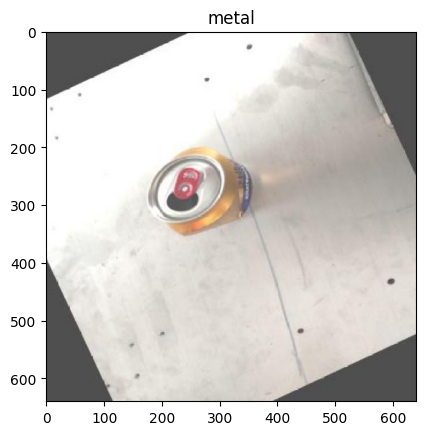

In [64]:
# # get a random image
# # total images number equals len(df)
idx = random.randint(0, len(df))

# get image by index
image_path = df['pathes'].iloc[idx]

# open an image
image = Image.open(image_path)

# make transformations
trfs = transforms.Compose([transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            # Use mean and std for pretrained models
                            # https://pytorch.org/docs/stable/torchvision/models.html
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])])

model.to(device)
model.eval()
prediction = model(torch.unsqueeze(trfs(image),dim=0).to(device))

pred = prediction.cpu().detach().numpy()
pred = np.exp(pred) / np.exp(pred).sum()
lbl = np.argmax(pred)

plt.imshow(image)
plt.title('plastic' if lbl == 0 else 'metal')
plt.show()